In this notebook, I select the optimal number of latent features C, the hyperparameter used in our nonnegative matrix factorization notebook. 

I used the method described by Alex Williams here: http://alexhwilliams.info/itsneuronalblog/2018/02/26/crossval/

This notebook is copied from an implementation by Ishay Telavivi (with minor tweaks) that is available here: https://github.com/IshayTelavivi/cross_validation_matrix_completion/blob/master/cv_for_nmf_sample1.ipynb

In [5]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import linalg
import math
import random

First, we need to load the data and preprocess it in the same way we will in the final version. This involves grouping on authors, then weighting the counts with a chosen weighting scheme (TF-IDF or PMI).

In [22]:
# load data
df = pd.read_csv('../data/processed/book_reviews.tsv', sep='\t', index_col=0)
df['author_name'] = df.index.to_series().str.split('\\|\\|').str[1].str.strip()
author_total_books = df['author_name'].value_counts()
df = df.groupby('author_name').sum()
df = df[df.index.notnull()]
df = df.drop('#NAME?')

# drop low-count authors and journals
auth_min = 20
journal_min = 25
df = df[df.sum(axis=1) >= auth_min]
df = df[df.columns[df.sum() >= journal_min]]
df.shape

# weight values
docs = df.shape[0]
idfs = [math.log(docs / np.where(df[col] == 0, 0, 1).sum()) for col in df.columns]
tfidf = df * idfs

# finally, shuffle the data
tfidf = tfidf.sample(frac=1, random_state=99) # rows
random.seed(99)
shuffled_cols = list(tfidf.columns)
random.shuffle(shuffled_cols)
tfidf = tfidf[shuffled_cols] # columns

tfidf.head()

,Journal of American History,Humanist,Sewanee Review,American City and Council,Encounter,Parnassus: Poetry in Review,Instructor,Review of Metaphysics,American Anthropologist,Harvard Law Review,...,American Forests,Church History,Parks and Recreation,English Journal,British Book News,Philosophical Review,Western Humanities Review,Journal of English and Germanic Philology,American Literature,Washington Monthly
author_name,,,,,,,,,,,,,,,,,,,,,
"CARR, Rachel",0.0,0.0,0.000000,0.0,0.0,0.000000,2.441518,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"YAU, John",0.0,0.0,0.000000,0.0,0.0,4.577147,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"SIMON, Roger L",0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"PERELMAN, S J",0.0,0.0,2.659276,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"JACOBSON, Willard J",0.0,0.0,0.000000,0.0,0.0,0.000000,24.415180,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The following function splits the matrix into 4 sets for crossvalidation. In each one, 1/4 of the values are masked with zeroes.

In [23]:
def crossval_matrices(X, fold):
    """
    Given a matrix X, the function creates 4 sets of train + test matrices
    where each train matrix is masked with zeros in 0.25 of the values, and the
    test matrix is masked zeros in 0.75 of them.
    X - numpy array
    fold - is an integer from 0-3.
    Returns the masked data and also the masks for train and test
    """
    # Create a dict with the slicing indices
    rows = X.shape[0]
    cols = X.shape[1]
    mid_rows = int(rows/2)
    mid_cols = int(cols/2)
    
    idx_dict = {
                0: [[0,mid_rows],[0, mid_cols]],
                1: [[0,mid_rows],[mid_cols, cols]],
                2: [[mid_rows, rows], [0, mid_cols]],
                3: [[mid_rows, rows], [mid_cols, cols]]
    }
    
    idexes = idx_dict[fold]
    # Create masks
    train_mask = np.full((rows, cols), 1)
    train_mask[idexes[0][0]:idexes[0][1], idexes[1][0]:idexes[1][1]] = 0
    test_mask = 1 - train_mask
    
    
    # Create X_train
    X_train = X.copy()
    X_train[train_mask==0] = 0
    
    # Create X_test
    X_test = X.copy()
    X_test[train_mask==1] = 0
        
    return X_train, X_test, train_mask, test_mask

In [139]:
from sklearn.decomposition import NMF

# note that unlike the original, this version assumes no actual NaN values are in the data
def nmf_crossval(X, latent_features, cycles=5, max_iter=500):
    """
    Performs NMF with 1/4 of the data held out, decomposing matrix X to lower rank matrices W and H.
    Calculates training and test error based on divergence of WH from training X and test (held-out) X.
    """
    
    # fold_tups is where we collect the attributes from each fold
    fold_tups = []
    
    # Cross validation by 4 folds
    for f in range(4):
        X_train, X_test, train_mask, test_mask = crossval_matrices(X, f)
        
        # Get only the train values
        masked_X = train_mask * X_train
        model = NMF(n_components=latent_features, 
                        init='nndsvd', # nndsvd is faster with a sparse matrix
                        random_state=99, 
                        max_iter=max_iter)
        W = model.fit_transform(X_train)
        H = model.components_
        X_est = np.dot(W, H) # estimated reconstruction of source matrix
        train_err = linalg.norm(train_mask * (X_train - X_est), ord='fro')
        test_err = linalg.norm(test_mask * (X_test - X_est), ord='fro')

        fold_tup = (W, H, train_err, test_err)
        fold_tups.append(fold_tup)
        
        print('k: ', latent_features, ';  fold: ', f) 
        print('train residual', np.round(train_err, 4))
        print('test residual', np.round(test_err, 4))
        print()
        
    # Get avg train/test score from all folds
    train_mean = np.mean([x[2] for x in fold_tups])
    test_mean = np.mean([x[3] for x in fold_tups])
    
    return train_mean, test_mean

In [140]:
# Run multiple k and capture results

n_iter = 5000
k_tup_list = []
data = tfidf + 1
k_min = 2
for k in range(k_min,30):     

    train_mean, test_mean = nmf_crossval(data, k, max_iter=n_iter)
    k_tup = (train_mean, test_mean, k)
    k_tup_list.append(k_tup)

k:  2 ;  fold:  0
train residual 1722.4158
test residual 1450.3628

k:  2 ;  fold:  1
train residual 1677.9981
test residual 1494.2566

k:  2 ;  fold:  2
train residual 1730.0207
test residual 1432.9131

k:  2 ;  fold:  3
train residual 1694.0769
test residual 1471.5327

k:  3 ;  fold:  0
train residual 1627.1642
test residual 1416.612

k:  3 ;  fold:  1
train residual 1581.844
test residual 1457.9668

k:  3 ;  fold:  2
train residual 1633.1164
test residual 1397.7841

k:  3 ;  fold:  3
train residual 1596.3219
test residual 1435.469

k:  4 ;  fold:  0
train residual 1579.97
test residual 1414.8092

k:  4 ;  fold:  1
train residual 1535.3087
test residual 1438.0591

k:  4 ;  fold:  2
train residual 1585.7068
test residual 1394.8237

k:  4 ;  fold:  3
train residual 1546.5136
test residual 1412.8556

k:  5 ;  fold:  0
train residual 1546.6095
test residual 1409.3642

k:  5 ;  fold:  1
train residual 1508.0378
test residual 1444.0499

k:  5 ;  fold:  2
train residual 1545.6905
test resid

In [ ]:
# Extracting the best run for K in range 2-30, step 1
test_err = [tup[1] for tup in k_tup_list]
min_test_err = np.min(test_err)
min_test_err_idx = test_err.index(min_test_err)
best_k = min_test_err_idx + k_min

test_vals = [x[1] for x in k_tup_list]
train_vals = [x[0] for x in k_tup_list]
# plot
plt.plot(np.arange(2,len(train_vals)+2), train_vals, label="train")
plt.plot(np.arange(2,len(test_vals)+2), test_vals, label="test")
plt.title("Training and test error for various K")
plt.xlabel("K")
plt.ylabel("error")
plt.legend()
plt.show()

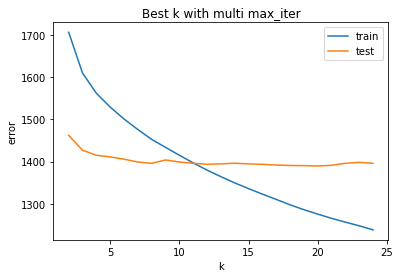

Best (lowest) error is 1389.6590211863545, with 20 latent features


In [66]:
# Extracting the best run for K in range 2-24, step 1
test_err = [tup[1] for tup in k_tup_list]
min_test_err = np.min(test_err)
min_test_err_idx = test_err.index(min_test_err)
best_k = min_test_err_idx + k_min

test_vals = [x[1] for x in k_tup_list]
train_vals = [x[0] for x in k_tup_list]
# plot
plt.plot(np.arange(2,len(train_vals)+2), train_vals, label="train")
plt.plot(np.arange(2,len(test_vals)+2), test_vals, label="test")
plt.title("Training and test error for various K")
plt.xlabel("K")
plt.ylabel("error")
plt.legend()
plt.show()

print("Best (lowest) error is {}, with {} latent features".format(min_test_err, best_k))